# Car Make Classifier: Full Scale

In the modern automotive industry, visual brand identity plays a crucial role. Each car manufacturer designs vehicles with unique styling elements—from grille shape to headlight design—that make their cars instantly recognizable. 

In this project, we aim to harness the power of image classification using deep learning to build a model that can automatically identify whether a car in an image belongs to BMW, Porsche, Toyota, Peugeut, Tesla, Audi, etc.

### 🎯 Objective
For the initial model we are going to feed it with images from one of the most immediatelly recognizable cars: **Audi**, **BMW** and **Mercedes**.

The goal is to develop a machine learning model that takes a full image of a car and correctly classifies it as one of the brands from above. The model will be trained on a curated image dataset and evaluated on its ability to generalize to new, unseen car images.

-----

## 🌐 Domain Context
In today's digital landscape, apps that leverage computer vision are becoming increasingly prevalent across industries — from retail and security to automotive technology. Within the automotive domain, identifying the make of a vehicle from a photo has practical value in multiple applications: car listing platforms, mobile parking apps, AI-powered insurance inspections, and even driver-assistance systems.

Ultimately, this project demonstrates how AI can bridge the gap between real-world visual data and intelligent brand recognition, opening the door for smarter, image-driven applications in the automotive and consumer tech space.

In [1]:
import copy, pathlib, math
import PIL.Image as Image

import sklearn
import numpy
import matplotlib
import matplotlib.pyplot as plt

print("scikit-learn version:", sklearn.__version__)     # 1.2.2
print("numpy version:", numpy.__version__)              # 2.1.3
print("matplotlib version:", matplotlib.__version__)    # 3.10.2

scikit-learn version: 1.6.1
numpy version: 1.23.5
matplotlib version: 3.10.0


## 📦 Data Provisioning

For this project, the dataset was curated from various sources on the internet. Images representing three car brands—**Audi**, **BMW**, and **Mercedes**—were collected. The dataset includes a mix of clear, high-quality images typically used for car listings, as well as blurrier images captured from traffic cameras to ensure diversity and robustness in the model.

- **Brands:** Audi, BMW, Mercedes  
- **Image Count:** At least 50 images per brand, with some brands having more  
- **Image Variety:** Both clear/listing images and real-world, lower-quality images

All images are organized in subfolders named after their respective brands. This structure allows for straightforward loading and labeling during the data preparation phase. 

In [2]:
import os
from PIL import Image, UnidentifiedImageError


input_root = "car_dataset"
output_size = (224, 224)
accepted_formats = ('.jpg', '.jpeg', '.png')


for brand in os.listdir(input_root):
    brand_path = os.path.join(input_root, brand)
    if not os.path.isdir(brand_path):
        continue

    print(f"Processing: {brand}")
    count = 1 #Count for renaming the file names

    for filename in os.listdir(brand_path):
        file_path = os.path.join(brand_path, filename)

       # Checking if the file is an image based on its extension
        if not filename.lower().endswith(accepted_formats):
            print(f"Skipping non-image: {filename}")
            continue

        try:
            with Image.open(file_path) as img:
                img = img.convert("RGB") # Converting to RGB in case of PNG or other formats
                img = img.resize(output_size) # Resizing the images to 224x224

                new_filename = f"{brand.lower()}_{count:03}.jpg" # changing the name of the folder
                new_path = os.path.join(brand_path, new_filename)
                img.save(new_path, "JPEG")

                if filename != new_filename:
                    os.remove(file_path)

                count += 1

        except (UnidentifiedImageError, OSError) as e: #In case of corrupted images
            print(f"Removing corrupted file: {filename}")
            os.remove(file_path)

Processing: audi
Processing: bmw
Processing: mercedes


In [3]:
for brand in os.listdir("car_dataset"):
    print(f"{brand} has {len(os.listdir(os.path.join(input_root, brand)))} images.")

audi has 66 images.
bmw has 58 images.
mercedes has 55 images.


# 📃 Sample the data
To get an impression of the data, here a sample from the loaded images is plotted so see if they we loaded correctly.

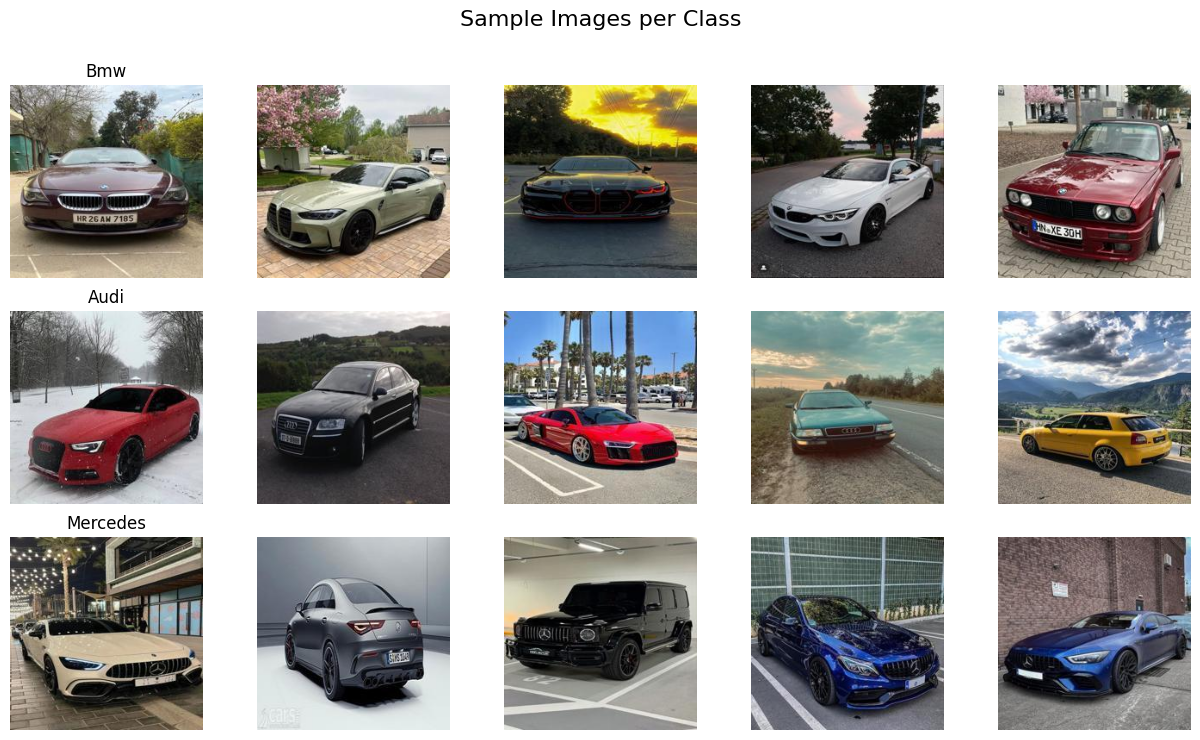

In [4]:
import random

classes = ["bmw", "audi", "mercedes"]
images_per_class = 5

fig, axes = plt.subplots(len(classes), images_per_class, figsize=(images_per_class * 2.5, len(classes) * 2.5))
fig.suptitle("Sample Images per Class", fontsize=16)

for row, cls in enumerate(classes):
    class_dir = os.path.join(input_root, cls)
    images = [f for f in os.listdir(class_dir) if f.lower().endswith(".jpg")]
    sampled = random.sample(images, min(images_per_class, len(images)))

    for col, img_file in enumerate(sampled):
        img_path = os.path.join(class_dir, img_file)
        img = Image.open(img_path).resize(output_size)

        ax = axes[row][col] if len(classes) > 1 else axes[col]
        ax.imshow(img)
        ax.axis("off")
        if col == 0:
            ax.set_title(cls.capitalize(), fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


# 🛠️ Preprocessing
Given that this case uses images, there is no such thing as feature selection because one cannot select some pixels to be better indicators than other pixels beforehand. Therefore, there is little to do in terms of preprocessing other than splitting the dataset into a trainset and testset.